# Preamble

We'll start by formatting the notebook, and running some diagnostics for checking the systems sound output is working correctly. Then, I've imported the Python modules required.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
"""
Windows audio host inspector.

This script will check if pyo can run in duplex mode (both audio input and output)
and will test every host API to help the user in making his audio device choice.

"""
import sys, time
from pyo import *

if sys.platform == "win32":
    host_apis = ["mme", "directsound", "asio", "wasapi", "wdm-ks"]
else:
    print("This program must be used on a windows system! Ciao!")
    exit()


print("* Checking for any available audio input... *")

input_names, input_indexes  = pa_get_input_devices()

print("* Checking audio output hosts... *")

s = Server(duplex=0)
s.verbosity = 0

host_results = []
for host in host_apis:
    print("* Testing %s... *" % host)
    try:
        s.reinit(buffersize=1024, duplex=0, winhost=host)
        s.boot().start()
        a = Sine(freq=440, mul=0.2).out()
        time.sleep(2)
        s.stop()
        s.shutdown()
        host_results.append(True)
    except:
        host_results.append(False)

print("\nResults")
print("-------\n")

if len(input_names):
    print("Duplex mode OK!")
    print("Initialize the Server with duplex=1 as argument.\n")
else:
    print("No input available. Duplex mode should be turned off.")
    print("Initialize the Server with duplex=0 as argument.\n")

for i, host in enumerate(host_apis):
    if host_results[i]:
        print("Host: %s  ==>  OK!" % host)
    else:
        print("Host: %s  ==>  Failed..." % host)

print("Initialize the Server with the desired host given to winhost argument.")

print("\nFinished!")

s = Server(sr=44100,duplex=1,winhost="wasapi").boot()
s.start()

* Checking for any available audio input... *
* Checking audio output hosts... *


In [3]:
import pyo

s = pyo.Server()
s.boot()
s.start()
s.setInputDevice(4)
s.setOutputDevice(4)

In [2]:
import matplotlib
import librosa 
import matplotlib.pyplot as plt ## For plots and visual data
import IPython.display as ipd ## For displaying audio widgets
import lightkurve as lk ## For generation of light curves
import matplotlib.pyplot as plt ## Standard visual data creation module
import librosa.display
import numpy as np
import os
import pandas as pd
import sqlite3 ## Database creation
import mysql.connector
import jupyterthemes
import math
import matplotlib.animation as animation
import random
import ffmpeg
import sys
import datetime
#sys.stdout = open(1, 'w')

from astronify.series import SoniSeries ## For sonifying the data
from lightkurve import search_targetpixelfile ## 2D pixel heatmaps etc.
from astropy.io import fits
from astropy.table import Table
from astronify import simulator, series
from celluloid import Camera
from pyo import *
from pathlib import Path
matplotlib.rcParams.update({'font.size': 22})

# Setting light curve parameters

Here we'll set some parameters for the curves we want to produce. With six values of signal-to-noise, and three values for the number of transits (0, 1 and 2, note 0 transit curves are done separately), 18 curves will be generated. 

From the values of SNR we want to test at, we can obtain a value for the corresponding standard deviation of noise which is calculated depending on the transits width and depth. This is what astronify takes as input for it's noise parameter. We can also obtain a parameter for the distance between transits which I've called freq_param. This equates to 1000 for curves of one transit, and 500 for curves of two.

In [9]:
snr = [3,5,7,10,30,100] # The signal to noise ratio we are testing for
transit_length = 1000 # Affects length of sonification, we wanted to keep this at about 10 seconds and 1000 was appropriate
t_depth = 25 # The depth of the transit as a percentage of the brightness flux
width_param = 0.1 # Transit length as fraction of total
transit_n = [1,2] # Number of transits we want in the data
t_width = transit_length*width_param # In our case, 100

noise_sd = [] 
for x in snr:
    noise_sd.append(np.sqrt(width_param*transit_length)*t_depth/x) ## The actual noise sigma values for astronify
    
freq_param = []
for x in transit_n:
    freq_param.append(int(transit_length/x)) # This is why zero-transit data is done separately

In [6]:
"Standard deviations of noise to put in are:" ,noise_sd

('Standard deviations of noise to put in are:',
 [83.33333333333333, 50.0, 35.714285714285715, 25.0, 8.333333333333334, 2.5])

In [7]:
"Transit periods:", freq_param

('Transit periods:', [1000, 500])

# Generating an example transit with noise and no noise

Now we're ready to start using astronify to generate transit light curves. We'll start with a curve of one transit, using the formula t_start to semi-randomize the position of the transit (this is to avoid it being directly at the start mainly).

Saving to the system is commented out.

Text(0, 0.5, 'Brightness flux (arbitrary units)')

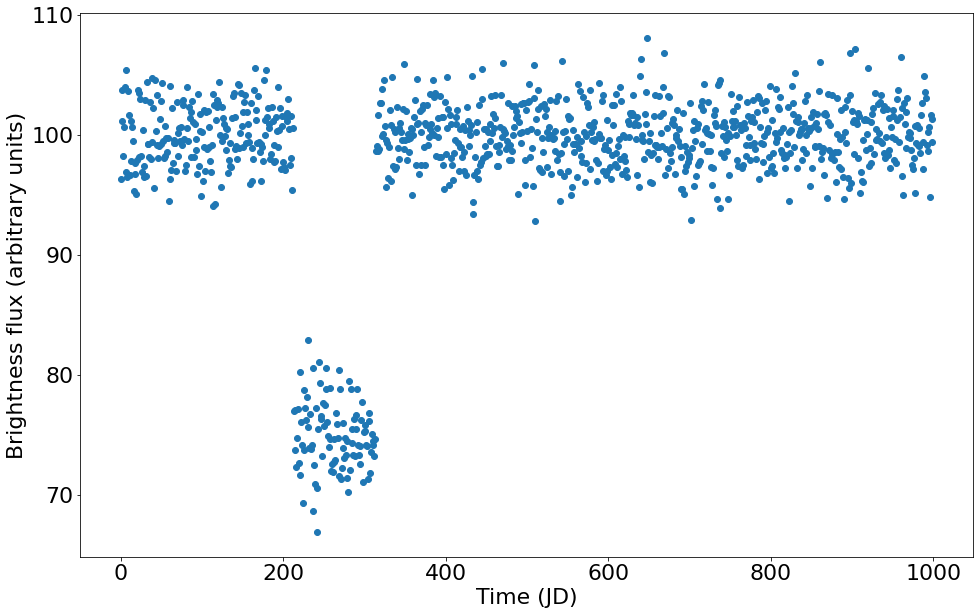

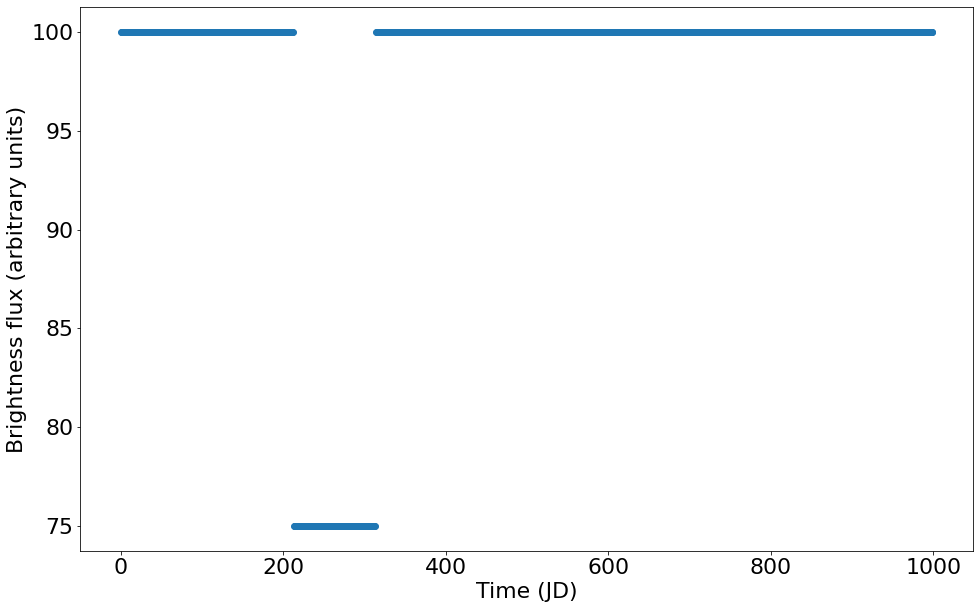

In [13]:
n_transit = 1
t_period = int(transit_length/n_transit)
t_start = int(transit_length/(2.*n_transit)-t_width/2. + random.randint(-1*t_period/4, t_period/4)) 

# For curves of one transit, it will start at ~half-way point, for two transits at ~quarter-way and three quarter-way points.
# Due to the randomness of the transit starts, the generated dataset won't be exactly the same as the one with which I 
# carried out the user testing.

lc_data_noise = simulator.simulated_lc("transit", visualize=False, 
                                       transit_depth=int(t_depth), transit_period=t_period,
                                       transit_width=int(t_width), lc_noise=2.5, 
                                       lc_length=int(transit_length),transit_start=t_start)

f, ax = plt.subplots(figsize=(16, 10))
ax.plot(lc_data_noise['time'], lc_data_noise['flux'],'-o', linewidth=0)
ax.set_xlabel("Time (JD)")
ax.set_ylabel("Brightness flux (arbitrary units)")

#plt.savefig("Example noisy transit.png")

lc_data_noiseless = simulator.simulated_lc("transit", visualize=False, 
                                           transit_depth=int(t_depth), transit_period=t_period,
                                           transit_width=int(t_width), lc_noise=0, 
                                           lc_length=int(transit_length),transit_start=t_start)

f, ax = plt.subplots(figsize=(16, 10))
ax.plot(lc_data_noiseless['time'], lc_data_noiseless['flux'],'-o', linewidth=0)
ax.set_xlabel("Time (JD)")
ax.set_ylabel("Brightness flux (arbitrary units)")

#plt.savefig("Example noiseless transit.png")

# Building database of the parameters for reference

Now we can prepare to build a database of light curves of varying parameters. As we need to refer back to the properties of these curves after the user testing, we'll create a database that contains the variables (number of transits and signal-to-noise) 

In [22]:
if 'df' in locals(): # To make sure we start with an empty database
    del df
else:
    df = pd.DataFrame({'Number of transits': [],
            'Value of SNR': [],
                     'Tag': []})
    display(df)

,Number of transits,Value of SNR,Tag


In [7]:
#s = Server(sr=44100, nchnls=2, buffersize=512, duplex=1).boot()
#s.start()

# Light curve generator

## Curves with 1 and 2 transits

So we can tell exactly what the generator is doing (just an iterative loop that creates curves for the two values in transit_n, 1 and 2, and the standard deviation values of noise) we'll also create a noiseless version of the curve for reference.

The actual code here is relatively simple - the important part is that k represents a randomized tag, that is assigned to each curve. This is so the curves are 'anonymous' to users, i.e. their SNR and number of transits are not in the filename, hence why having the database to refer back to each curves' properties is so essential.

In [24]:
for j in transit_n: ## Generating 12 transits for n = 1, n = 2
                   
    for i in noise_sd:

        t_start = int(transit_length/(2.*j)-(transit_length*width_param)/2. + 
                      random.randint(-1*(transit_length/j)/4, (transit_length/j)/4)) 
        
        k = int(random.uniform(0,100)) # k is generated, initally for no curve in the database.
        
        # architecture
        
        # if len(df) != 0:
        #      check k is not in any of the cells in df
        #      if it is, regenerate k and try again until it's safe
        
        # elif 
        #        continue
        
        for i in range(0,len(df['Tag'])):
            print(df.iloc[i]['Tag'])
        #if k in df.iloc['Tag'][i]
        
        lc_data_transit = simulator.simulated_lc("transit", 
                                         visualize = False, 
                                         transit_depth = 25,
                                         transit_period = transit_length/j, 
                                         transit_width = int(transit_length*width_param),
                                         transit_start = t_start,
                                         lc_noise = i, 
                                         lc_length = transit_length)
        
        lc_data_transit0 = simulator.simulated_lc("transit", 
                                         visualize = False, 
                                         transit_depth = 25,
                                         transit_period = transit_length/j, 
                                         transit_width = int(transit_length*width_param),
                                         transit_start = t_start,
                                         lc_noise = 0, 
                                         lc_length = transit_length)


        lc_sound_transit = series.SoniSeries(lc_data_transit)
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()
        
        lc_sound_transit0 = series.SoniSeries(lc_data_transit0)
        lc_sound_transit0.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit0.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit0_spacing = 0.01
        lc_sound_transit0.note_duration = 0.2
        lc_sound_transit0.sonify()
        #----------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ## ax.set_ylim(-500,500)
        ## ax.autoscale(enable=True, axis='both', tight=False)
        ax.set_ylabel("Flux")
        
        df=df.append({'Number of transits':int(j),
                      'Value of SNR':math.ceil((25*np.sqrt(transit_length*width_param))/(i+0.01)),
                      'Tag':k},
                      ignore_index=True)

        #plt.savefig("plot" + str(k) + ".jpg")

        plt.close()

        #lc_sound_transit.write("sonification" + str(k) + ".wav")
        #----------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit0['time'], lc_data_transit0['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ## ax.set_ylim(-500,500)
        ## ax.autoscale(enable=True, axis='both', tight=False)
        ax.set_ylabel("Flux")
        
        df=df.append({'Number of transits':int(j),
                      'Value of SNR':math.ceil((25*np.sqrt(transit_length*width_param))/(i+0.01)),
                      'Tag':k},
                      ignore_index=True)

        #plt.savefig("plot" + str(k) + "0.jpg")

        plt.close()

        #lc_sound_transit.write("sonification" + str(k) + "0.wav")


print("Generation of non-zero transit data finished")

Final result of our 'tag' database which is used for referring back to the curves properties.

In [10]:
display(df)

,Number of transits,Value of SNR,Tag
0,1.0,3.0,95.0
1,1.0,3.0,40.0
2,1.0,3.0,40.0
3,1.0,5.0,63.0
4,1.0,5.0,63.0
5,1.0,7.0,68.0
6,1.0,7.0,68.0
7,1.0,10.0,87.0
8,1.0,10.0,87.0
9,1.0,30.0,11.0


## Curves of zero transits

In [25]:
for i in noise_sd: ## Generating 6 transits for zero n (working code)

        j = int(random.uniform(100,200))   
    
        lc_data_transit = simulator.simulated_lc("flat", 
                                         visualize = False, 
                                         transit_depth = 25,
                                         transit_period = 100, 
                                         transit_width = int(transit_length*width_param),
                                         lc_noise = i, 
                                         lc_length = transit_length)


        lc_sound_transit = series.SoniSeries(lc_data_transit)
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()
        #----------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        # ax.set_ylim()
        ax.set_ylabel("Flux")

        df=df.append({'Number of transits':0,
                      'Value of SNR':math.ceil((25*np.sqrt(transit_length*width_param))/i),
                      'Tag':j},
                      ignore_index=True)

        plt.savefig("plot" + str(j) + ".jpg")

        plt.close()

        lc_sound_transit.write("sonification" + str(j) + ".wav")
        
print("Generation of zero transit data finished")

df

print("Confirming no overlap in random tagging, number of curves = ",len(df))

## Writing the dataframe to master spreadsheet

This is commented so that it doesn't overwrite my original data.

In [26]:
print(df)
#df.to_excel(r'C:\Users\jackt\OneDrive - Newcastle University\Project\Tag spreadsheet.xlsx', 
#            index = False)

## Writing ffmpeg files

Scriptable??

In [35]:
! C:\ffmpeg\bin\ffmpeg -loop 1 -i \
  C:\ffmpeg\plots\ex_noisy.jpg -i \
  C:\ffmpeg\sonifications\ex_noisy.wav \
  -c:v libx264 -tune stillimage -c:a aac -b:a 192k -pix_fmt yuv420p -shortest \
  C:\ffmpeg\combined\out_noisy.mp4

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 